# Experimental DECiSION code

In [1]:
RANDOM_STATE = 42
from numpy.random import seed
seed(RANDOM_STATE)

from tensorflow import set_random_seed
set_random_seed(RANDOM_STATE)

import random
random.seed = RANDOM_STATE

import DECiSION_settings as settings

from dltoolkit.utils.generic import model_architecture_to_file, model_summary_to_file, list_images
from dltoolkit.utils.image import normalise, normalise_single, standardise, standardise_single,\
    mean_subtraction, clahe_equalization, clahe_equalization_single, adjust_gamma_single
from dltoolkit.nn.segment import UNet_NN
from dltoolkit.utils.visual import plot_training_history
from dltoolkit.iomisc import HDF5Writer, HDF5Reader, HDF5Generator_Segment

from thesis_common import convert_img_to_pred, convert_pred_to_img,\
    group_images, show_image, read_preprocess_image, read_preprocess_groundtruth
from thesis_metric_loss import dice_coef, weighted_pixelwise_crossentropy_loss

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import numpy as np
import os, cv2, time, progressbar

import matplotlib.pyplot as plt
%matplotlib inline

/Users/geoff/anaconda3/envs/ML3-DL-OPENCV/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
hdf5_paths = ["../data/MSC8002/training/train_imgs.h5",
              "../data/MSC8002/training/train_masks.h5",
              "../data/MSC8002/training/val_imgs.h5",
              "../data/MSC8002/training/val_masks.h5"
              "../data/MSC8002/test/test_imgs.h5"]

## Test pre-processing

2: (320, 320) float32 -0.49607843 0.5


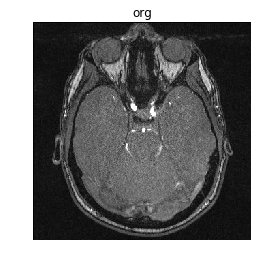

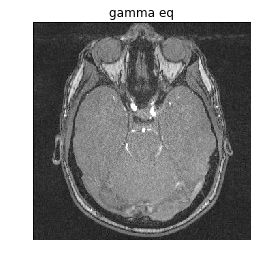

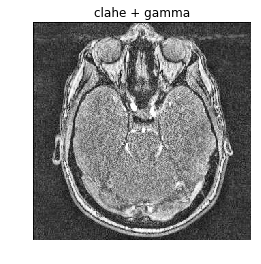

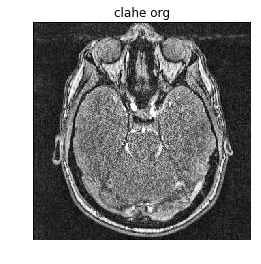

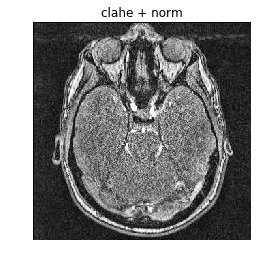

In [7]:
img = cv2.imread('../data/MSC8002/training/images/patient_1/S572080059.jpg', cv2.IMREAD_GRAYSCALE)
# print("1:", img.shape, img.dtype, np.min(img), np.max(img))

# img = normalise_single(img)
# img = (img/255.0).astype("float32")
# print("2:", img.shape, img.dtype, np.min(img), np.max(img))

equ = cv2.equalizeHist(img)
gam = adjust_gamma_single(img, 1.5)

clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(16, 16))
equ_cl = clahe.apply(gam)
equ_org = clahe.apply(img)

equ_norm = (equ_org/255.0-0.5).astype(np.float32)
print("2:", equ_norm.shape, equ_norm.dtype, np.min(equ_norm), np.max(equ_norm))


# print(equ.shape, equ.dtype)

# show_image(np.hstack((equ_cl, img)), "")
# show_image(np.hstack((equ, img)), "")

show_image(img, "org")
show_image(gam, "gamma eq")
show_image(equ_cl, "clahe + gamma")
show_image(equ_org, "clahe org")
show_image(equ_norm, "clahe + norm")

## Test reading batches of images

In [4]:
data_gen_args = dict(rotation_range=2.,
                     width_shift_range=0.01,
                     height_shift_range=0.01,
                     shear_range=1.2,
                     zoom_range=0.01,
                     fill_mode='nearest')

rdr = HDF5Generator_Segment(hdf5_paths[0], hdf5_paths[1],
                            batch_size=4,
                            data_gen_args=data_gen_args,
                            feat_key=settings.HDF5_KEY)

lala = rdr.generator(settings=settings, num_epochs=1)

for ix, (imgs, grt) in enumerate(lala):
    print("imgs {}, grt: {}".format(imgs.shape, grt.shape))
    group_images(imgs[0:9], 3, 0.0, False, "../output/test_grp_images"+str(ix))
    group_images(grt[0:9], 3, 1.0, False, "../output/test_grp_grts"+str(ix))

imgs (4, 240, 240, 1), grt: (4, 240, 240, 1)
imgs (4, 240, 240, 1), grt: (4, 240, 240, 1)
imgs (1, 240, 240, 1), grt: (1, 240, 240, 1)


## Determine reduced image size

In [ ]:
img = cv2.imread('../data/MSC8002/training/images/patient_1/S572080059.jpg', cv2.IMREAD_GRAYSCALE)

img_shape = img.shape

print("shape: {}".format(img_shape))

CROP_PIXELS_Y = 40
CROP_PIXELS_X = 40

cv2.rectangle(img, (CROP_PIXELS_X, CROP_PIXELS_Y),
                         (img_shape[1]-CROP_PIXELS_X, img_shape[0]-CROP_PIXELS_Y), (255), 2)

img_crop = img[CROP_PIXELS_Y:img_shape[0]-CROP_PIXELS_Y,
               CROP_PIXELS_X:img_shape[1]-CROP_PIXELS_X]

print("Old shape: {}, new shape: {}".format(img.shape, img_crop.shape))
show_image(img, "org")
show_image(img_crop, "crop")